# Introduction

1. I might be doing the scalar multiplies with the transpose -- if things don't work, check here
2. Check the actor loss -- am I screwing things up with the tranposing?

3. Implement prioritized experience replay.


### Test on cartpole

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


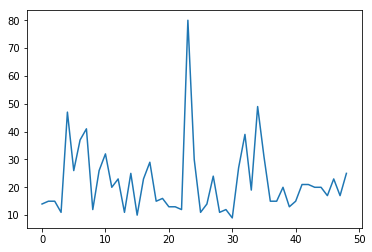

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import Agent
%matplotlib inline


#Environment
env = gym.make('CartPole-v0')
env.seed(0)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n


#Agent
lr,gamma,tau = 3*10**-4, 0.99, 0.01, 
clipnorm, verbose, alpha = True, False, 0.001
agent = Agent(input_dim, output_dim, lr, gamma, tau, alpha, clipnorm, verbose)
agent.memory_size = 10000
agent.batchsize = 32


#Train
EPISODES = 49
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = agent.make_tensor(state)
    reward_sum = 0
    done = False
    while not done:
        
        #Do main step
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        next_state = agent.make_tensor(next_state)
        agent.remember(state[0],action,reward,next_state[0],done) #want to remember state as a vec
        state = next_state

        #Learn
        if e > 50:
            agent.learn()
            print 'probs = ' + str(agent.actor.model.predict(state))

    
    #Print results
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
plt.plot(scores)

In [3]:
agent.learn()
print 'probs = ' + str(agent.actor.model.predict(state))

probs = [[nan nan]]


agent.py:109: RuntimeWarning: invalid value encountered in less
  action = np.random.choice(self.actions, p=probs)


### Change actor network

In [12]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.utils import to_categorical

clipnorm = True

#Inputs
S_pl = agent.actor.model.input
A_pl = K.placeholder(shape=(None, agent.output_dim))  #onehot
Q_pl = K.placeholder(shape=(None,1))
V_pl = K.placeholder(shape=(None,1))

#Find terms in bracket
pi_vec = agent.actor.model.output
pi = K.sum(pi_vec*A_pl,axis=1)    # get \pi(s_t, a_t) -- prob for specific action
entropy = agent.alpha*K.log(pi)
temp = entropy - K.transpose(Q_pl) + K.transpose(V_pl)  #this is a row vec
temp = K.transpose(temp)      #turn it into col vec

#Find grad log(pi)
pi_pl = agent.actor.model.output
pars = agent.actor.model.trainable_weights
grads = tf.gradients( K.log(pi_pl), pars)   #scalar multiply by temp

#Clip gradients
if agent.actor.clipnorm == True:
    grads = tf.clip_by_global_norm(grads, 1.0)[0]
    
opt = Adam(lr=0.01)
loss = grads  #placeholder, I won't use it
updates = opt.get_updates(loss = grads, params = pars, grads = grads)
func = K.function(inputs = [S_pl, A_pl, Q_pl, V_pl], outputs = [grad for grad in grads], updates = updates)



S,A,R,S1,D = agent.get_batch()
Q = agent.criticQ.model.predict([S,A])
V_target = agent.criticV.target_model.predict(S1)  #value of NEXT state


print SQ,V_target
grads1 = func([S,A,Q,V_target])
[grad.max() for grad in grads1]

[[ 4.90996621e-02  8.27166731e-01 -4.82437971e-02 -1.08666138e+00]
 [-3.70632589e-03  1.29647936e-02  4.47048431e-02  1.99277824e-02]
 [ 2.74712919e-02  1.73092779e-01 -3.84289252e-02 -3.81857227e-01]
 [-1.66010814e-03  3.69771874e-01 -3.76861977e-02 -6.78140976e-01]
 [ 4.66756319e-02  5.29035279e-02 -1.21238246e-01 -2.37973359e-01]
 [ 4.03257749e-02  7.99369599e-01 -1.92499663e-01 -1.50384950e+00]
 [-1.21140633e-01 -1.18956503e+00  1.94836309e-01  1.89443826e+00]
 [ 2.77088948e-02  1.47569492e-02 -3.03030440e-03  5.30621183e-03]
 [ 2.98799450e-01  1.57004505e+00 -1.90071759e-01 -1.96127059e+00]
 [-3.88825559e-02 -2.43726979e-01 -8.08832335e-03  2.15563173e-01]
 [ 5.73532934e-03  1.75193193e-01 -5.12490172e-02 -3.97557313e-01]
 [-9.83942930e-02 -2.25245694e-01  7.02999329e-02  3.12757407e-01]
 [ 4.03257749e-02  7.99369599e-01 -1.92499663e-01 -1.50384950e+00]
 [-3.09529354e-02  1.48912782e-01 -4.59852425e-02 -4.23035746e-01]
 [-1.07052961e-01 -6.10144693e-01  1.09792700e-01  1.00925891e

[nan, nan, nan, nan, nan, nan]